In [1]:
#!/usr/bin/env python3
"""
Architettura:
         D (1.0 GHz)
            │
   (L1: 100 Mbps, 10 ms)
            │
         E1 (1.5 GHz)
            │
   (L2: 1 Gbps, 1 ms)
            │
         E2 (2.5 GHz)
            │
   (L3: 1 Gbps, 1 ms)
            │
         E3 (2.5 GHz)
            │
   (L4: 10 Mbps, 30 ms)
            │
         C (4.0 GHz)
"""

import math
import itertools
import pandas as pd
import os
import glob

# nodi con frequenza e  gerarchia.
nodes = {
    'D':  {'freq': 0.9, 'order': 0},
    'E1': {'freq': 1.5, 'order': 1},
    'E2': {'freq': 2.5, 'order': 2},
    'E3': {'freq': 2.5, 'order': 3},
    'C':  {'freq': 4.0, 'order': 4}
}

#  link, le chiavi sono tuple (from_order, to_order)
links = {
    (0, 1): {'bandwidth': 100e6, 'delay': 0.01},  # L1: D -> E1
    (1, 2): {'bandwidth': 1e9,   'delay': 0.001},  # L2: E1 -> E2
    (2, 3): {'bandwidth': 1e9,   'delay': 0.001},  # L3: E2 -> E3
    (3, 4): {'bandwidth': 10e6,  'delay': 0.03}     # L4: E3 -> C
}

# GFLOPS richiesti ed output (in KB)
blocks = {
    1: {'gflops': 0.014, 'output_kb': 1568.00},
    2: {'gflops': 0.028, 'output_kb': 784.00},
    3: {'gflops': 0.082, 'output_kb': 392.00},
    4: {'gflops': 0.079, 'output_kb': 196.00},
    5: {'gflops': 0.287, 'output_kb': 98.00},
    6: {'gflops': 0.078, 'output_kb': 4.00},
    7: {'gflops': 0.001, 'output_kb': 3.91}
    #7: {'gflops': 20, 'output_kb': 3.91}
}

# Input iniziale dal nodo D per il blocco 1 (in KB)
input_size_kb = 300

def compute_block_time(block, node):
    """
    Calcola il tempo computazionale per eseguire un blocco su un nodo.
    Tempo = (GFLOPS richiesti) / (Frequenza del nodo in GHz)
    """
    return block['gflops'] / node['freq']

def transmission_time(data_kb, from_order, to_order):
    """
    Calcola il tempo di trasmissione per inviare data (in KB) da un nodo
    con "order" from_order a un nodo con "order" to_order.
    Il tempo su ogni link = (dati in bit / bandwidth) + delay.
    Se non c'è traversata (stesso nodo), ritorna 0.
    """
    if from_order == to_order:
        return 0.0

    total_time = 0.0
    if from_order < to_order:
        for order in range(from_order, to_order):
            link = links[(order, order+1)]
            data_bits = data_kb * 1024 * 8  # 1 KB = 1024 byte, 1 byte = 8 bit
            tx_time = data_bits / link['bandwidth'] + link['delay']
            total_time += tx_time
    else:
        for order in range(from_order, to_order, -1):
            link = links[(order-1, order)]
            data_bits = data_kb * 1024 * 8
            tx_time = data_bits / link['bandwidth'] + link['delay']
            total_time += tx_time

    return total_time

def simulate_inference_result(node_assignment):
    """
    Simula l'inferenza in split, dato l'assegnamento dei blocchi ai nodi.
    Ritorna un dizionario con i tempi totali e altre info.
    """
    total_compute_time = 0.0
    total_comm_time = 0.0
    

    t_tx = transmission_time(input_size_kb, nodes['D']['order'], nodes[node_assignment[1]]['order'])
    total_comm_time += t_tx

    for b in sorted(blocks.keys()):
        node_name = node_assignment[b]
        compute_time = compute_block_time(blocks[b], nodes[node_name])
        total_compute_time += compute_time

        if b < max(blocks.keys()):
            next_node_name = node_assignment[b+1]
            data_kb = blocks[b]['output_kb']
            t_tx = transmission_time(data_kb, nodes[node_name]['order'], nodes[next_node_name]['order'])
            total_comm_time += t_tx

    total_time = total_compute_time + total_comm_time

    return {
        'assignment': node_assignment.copy(),
        'total_compute_time': total_compute_time,
        'total_comm_time': total_comm_time,
        'total_inference_time': total_time
    }

def simulate_inference(node_assignment, print_result=True):
    """
    Esegue la simulazione e stampa un riepilogo dettagliato per una data assegnazione.
    """
    node_compute = {node: {'blocks': [], 'gflops_total': 0.0, 'compute_time': 0.0} for node in nodes}
    total_compute_time = 0.0
    total_comm_time = 0.0
    comm_times = {}
    block_times = {}

    
    t_tx = transmission_time(input_size_kb, nodes['D']['order'], nodes[node_assignment[1]]['order'])
    comm_times["D->Block1"] = t_tx
    total_comm_time += t_tx

    
    for b in sorted(blocks.keys()):
        node_name = node_assignment[b]
        compute_time = compute_block_time(blocks[b], nodes[node_name])
        block_times[b] = compute_time

        node_compute[node_name]['blocks'].append(b)
        node_compute[node_name]['gflops_total'] += blocks[b]['gflops']
        node_compute[node_name]['compute_time'] += compute_time
        total_compute_time += compute_time

        if b < max(blocks.keys()):
            next_node_name = node_assignment[b+1]
            data_kb = blocks[b]['output_kb']
            tx_key = f"Block{b}->Block{b+1}"
            t_tx = transmission_time(data_kb, nodes[node_name]['order'], nodes[next_node_name]['order'])
            comm_times[tx_key] = t_tx
            total_comm_time += t_tx

    total_time = total_compute_time + total_comm_time

    if print_result:
        print("=== Riepilogo esecuzione per nodo ===")
        print("{:<10} {:<15} {:<20} {:<15} {:<15}".format("Nodo", "CPU (GHz)", "Blocchi eseguiti", "GFLOPS Totali", "Tempo Computo (s)"))
        for node, info in node_compute.items():
            print("{:<10} {:<15} {:<20} {:<15.3f} {:<15.3f}".format(node, nodes[node]['freq'], str(info['blocks']), info['gflops_total'], info['compute_time']))
        print()
        
        print("=== Tempi di trasmissione ===")
        for key, t in comm_times.items():
            print(f"{key}: {t:.5f} s")
        print()
        
        print("Tempo totale di calcolo: {:.5f} s".format(total_compute_time))
        print("Tempo totale di comunicazione: {:.5f} s".format(total_comm_time))
        print("Tempo totale di inferenza: {:.5f} s".format(total_time))
    
    return {
        'node_compute': node_compute,
        'comm_times': comm_times,
        'total_compute_time': total_compute_time,
        'total_comm_time': total_comm_time,
        'total_inference_time': total_time
    }

# se True, esegue la simulazione su tutte le possibili combinazioni di placement
simulate_all = True

# percorso della cartella di output per i file Excel
output_folder = r"C:\Users\giorg\Downloads\flower\mobilenet\flops\mob"
base_excel_filename = "simulation_results.xlsx"
single_sim_excel_path = os.path.join(output_folder, "single_simulation_results.xlsx")

if simulate_all:
    # Simulazione di tutte le possibili combinazioni
    nodes_list = list(nodes.keys())
    all_assignments = list(itertools.product(nodes_list, repeat=len(blocks)))
    results = []
    print("Simulazione di tutte le combinazioni (totale {} configurazioni) in corso...".format(len(all_assignments)))
    
    for assignment_tuple in all_assignments:
        assignment = {i+1: assignment_tuple[i] for i in range(len(assignment_tuple))}
        sim_result = simulate_inference_result(assignment)
        sim_result_flat = {
            'block1': assignment[1],
            'block2': assignment[2],
            'block3': assignment[3],
            'block4': assignment[4],
            'block5': assignment[5],
            'block6': assignment[6],
            'block7': assignment[7],
            'total_compute_time': sim_result['total_compute_time'],
            'total_comm_time': sim_result['total_comm_time'],
            'total_inference_time': sim_result['total_inference_time']
        }
        results.append(sim_result_flat)
    
    df = pd.DataFrame(results)
    df.sort_values(by="total_inference_time", inplace=True)
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    excel_path = os.path.join(output_folder, base_excel_filename)
    df.to_excel(excel_path, index=False)
    print("Simulazione completata. Risultati salvati in '{}'.".format(excel_path))
    display(df)
    
    
    best_row = df.iloc[0]
    best_assignment = {
        1: best_row['block1'],
        2: best_row['block2'],
        3: best_row['block3'],
        4: best_row['block4'],
        5: best_row['block5'],
        6: best_row['block6'],
        7: best_row['block7']
    }
    print("\n=== Migliore configurazione (tempo inferenza minimo) ===")
    simulate_inference(best_assignment, print_result=True)
    
else:
    # Simulazione singola
    assignment = {
        1: 'E1',    
        2: 'E1',
        3: 'E2',
        4: 'E2',
        5: 'E2',
        6: 'E3',
        7: 'E3'
    }
    sim_result = simulate_inference_result(assignment)
    sim_result_flat = {
        'block1': assignment[1],
        'block2': assignment[2],
        'block3': assignment[3],
        'block4': assignment[4],
        'block5': assignment[5],
        'block6': assignment[6],
        'block7': assignment[7],
        'total_compute_time': sim_result['total_compute_time'],
        'total_comm_time': sim_result['total_comm_time'],
        'total_inference_time': sim_result['total_inference_time']
    }
    new_df = pd.DataFrame([sim_result_flat])
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    if os.path.exists(single_sim_excel_path):
        old_df = pd.read_excel(single_sim_excel_path)
        combined_df = pd.concat([old_df, new_df], ignore_index=True)
        combined_df.to_excel(single_sim_excel_path, index=False)
    else:
        new_df.to_excel(single_sim_excel_path, index=False)
    
    print("Simulazione singola completata. Risultati salvati (append) in '{}'.".format(single_sim_excel_path))
    display(pd.read_excel(single_sim_excel_path))
    
    print("\n=== Riepilogo dettagliato della simulazione singola ===")
    simulate_inference(assignment, print_result=True)


Simulazione di tutte le combinazioni (totale 78125 configurazioni) in corso...
Simulazione completata. Risultati salvati in 'C:\Users\giorg\Downloads\flower\mobilenet\flops\mob\simulation_results.xlsx'.


,block1,block2,block3,block4,block5,block6,block7,total_compute_time,total_comm_time,total_inference_time
39062,E2,E2,E2,E2,E2,E2,E2,0.227600,0.038034,0.265634
39063,E2,E2,E2,E2,E2,E2,E3,0.227600,0.039066,0.266666
39061,E2,E2,E2,E2,E2,E2,E1,0.227867,0.039066,0.266933
39068,E2,E2,E2,E2,E2,E3,E3,0.227600,0.039836,0.267436
39093,E2,E2,E2,E2,E3,E3,E3,0.227600,0.040639,0.268239
...,...,...,...,...,...,...,...,...,...,...
65020,C,D,C,D,D,C,D,0.482389,3.138468,3.620856
65101,C,D,C,D,C,D,E1,0.301972,3.324956,3.626928
65102,C,D,C,D,C,D,E2,0.301706,3.325989,3.627694
65103,C,D,C,D,C,D,E3,0.301706,3.327022,3.628727



=== Migliore configurazione (tempo inferenza minimo) ===
=== Riepilogo esecuzione per nodo ===
Nodo       CPU (GHz)       Blocchi eseguiti     GFLOPS Totali   Tempo Computo (s)
D          0.9             []                   0.000           0.000          
E1         1.5             []                   0.000           0.000          
E2         2.5             [1, 2, 3, 4, 5, 6, 7] 0.569           0.228          
E3         2.5             []                   0.000           0.000          
C          4.0             []                   0.000           0.000          

=== Tempi di trasmissione ===
D->Block1: 0.03803 s
Block1->Block2: 0.00000 s
Block2->Block3: 0.00000 s
Block3->Block4: 0.00000 s
Block4->Block5: 0.00000 s
Block5->Block6: 0.00000 s
Block6->Block7: 0.00000 s

Tempo totale di calcolo: 0.22760 s
Tempo totale di comunicazione: 0.03803 s
Tempo totale di inferenza: 0.26563 s


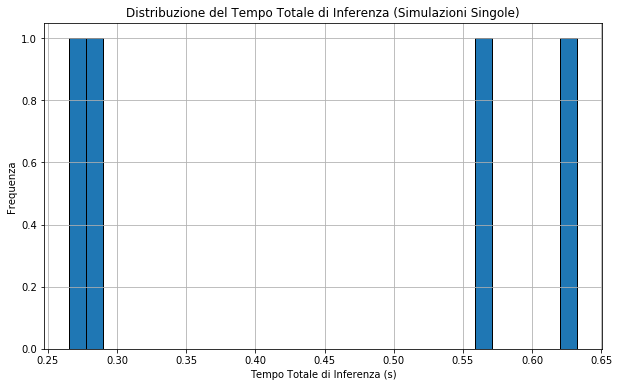

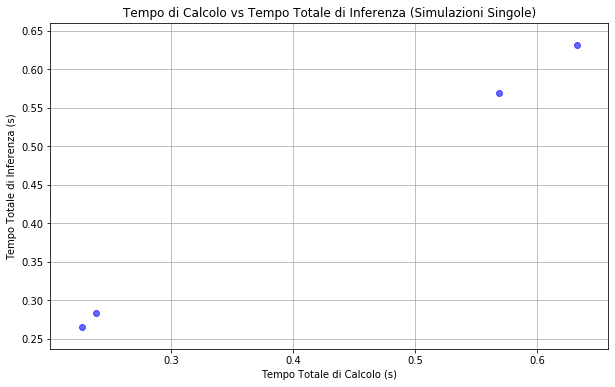

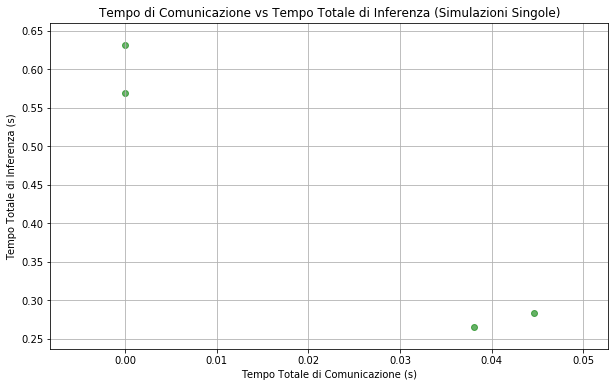

In [55]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


output_folder = r"C:\Users\giorg\Downloads\flower\mobilenet\flops\mob"
single_sim_excel_path = os.path.join(output_folder, "single_simulation_results.xlsx")


df_single = pd.read_excel(single_sim_excel_path)


plt.figure(figsize=(10,6))
plt.hist(df_single['total_inference_time'], bins=30, edgecolor='black')
plt.title("Distribuzione del Tempo Totale di Inferenza (Simulazioni Singole)")
plt.xlabel("Tempo Totale di Inferenza (s)")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(df_single['total_compute_time'], df_single['total_inference_time'], 
            alpha=0.6, color='blue')
plt.title("Tempo di Calcolo vs Tempo Totale di Inferenza (Simulazioni Singole)")
plt.xlabel("Tempo Totale di Calcolo (s)")
plt.ylabel("Tempo Totale di Inferenza (s)")
plt.grid(True)
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(df_single['total_comm_time'], df_single['total_inference_time'], 
            alpha=0.6, color='green')
plt.title("Tempo di Comunicazione vs Tempo Totale di Inferenza (Simulazioni Singole)")
plt.xlabel("Tempo Totale di Comunicazione (s)")
plt.ylabel("Tempo Totale di Inferenza (s)")
plt.grid(True)
plt.show()


fig = px.scatter_3d(df_single,
                    x='total_compute_time',
                    y='total_comm_time',
                    z='total_inference_time',
                    color='total_inference_time',
                    title="Interactive 3D Scatter: Simulazioni Singole",
                    labels={
                        "total_compute_time": "Tempo di Calcolo (s)",
                        "total_comm_time": "Tempo di Comunicazione (s)",
                        "total_inference_time": "Tempo Totale di Inferenza (s)"
                    })
fig.update_traces(marker=dict(size=5))
fig.show()
